# Microservices Workload Prediction Experiment

This notebook demonstrates workload prediction using the Alibaba Microservices Trace v2022 dataset.

## Contents
1. Data Loading and Exploration
2. Data Analysis and Visualization
3. Data Preprocessing
4. Model Training and Evaluation
5. Results Comparison


# Environment

nvidia rtx 5090
cuda 13.0

## 1. Setup and Imports


In [1]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Add project path
project_path = '/root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

# Import project modules
from config import DATA_CONFIG, MODEL_CONFIG, EXPERIMENT_CONFIG, create_output_dirs
from data_loader import DataModule, MSMetricsLoader, MSRTMCRLoader
from data_analysis import WorkloadAnalyzer, WorkloadVisualizer, analyze_dataset
from models import create_model, LSTMPredictor, GRUPredictor, TransformerPredictor
from trainer import (
    WorkloadTrainer, 
    run_deep_learning_experiment,  # Updated function name
    compare_all_models,            # Updated function name
    compute_metrics,
    print_metrics
)
from baseline_models import get_all_baseline_models, compare_baselines  # New baseline models

# Create output directories
create_output_dirs()

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('Setup complete!')
print(f'Data root: {DATA_CONFIG.data_root}')
print(f'Output directory: {EXPERIMENT_CONFIG.output_dir}')


Setup complete!
Data root: /root/autodl-tmp/clusterdata/data
Output directory: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs


## 2. Data Loading


In [2]:
# Initialize data module
dm = DataModule()

# Load MSMetrics data (adjust num_files based on your data)
# Each file covers 30 minutes, so:
#   4 files = 2 hours, 24 files = 12 hours (full dataset)
NUM_MSMETRICS_FILES = 24  # Use all available data for better results
LOAD_MSRTMCR = False      # Set True to load call rate/response time features

print('Loading data...')
dm.load_data(
    num_msmetrics_files=NUM_MSMETRICS_FILES,
    load_msrtmcr=LOAD_MSRTMCR,
    verbose=True
)


Loading data...
Loading MSMetrics data...
Loaded MSMetrics file 5/24
Loaded MSMetrics file 10/24
Loaded MSMetrics file 15/24
Loaded MSMetrics file 20/24
Total MSMetrics records: 336,805,458

MSMetrics Data Shape: (336805458, 6)
Unique microservices: 28,213
Timestamp range: 0 - 43140000


In [3]:
# Examine the loaded data
print('\nData shape:', dm.msmetrics_data.shape)
print('\nColumn names:', dm.msmetrics_data.columns.tolist())
print('\nData types:')
print(dm.msmetrics_data.dtypes)
print('\nFirst few rows:')
dm.msmetrics_data.head(10)



Data shape: (336805458, 6)

Column names: ['timestamp', 'msname', 'msinstanceid', 'nodeid', 'cpu_utilization', 'memory_utilization']

Data types:
timestamp               int64
msname                 object
msinstanceid           object
nodeid                 object
cpu_utilization       float64
memory_utilization    float64
dtype: object

First few rows:


,timestamp,msname,msinstanceid,nodeid,cpu_utilization,memory_utilization
0,2040000,MS_16981,MS_16981_POD_3,NODE_40866,0.079290,0.488760
1,2160000,MS_30422,MS_30422_POD_21,NODE_16227,0.118238,0.138268
2,2160000,MS_16601,MS_16601_POD_667,NODE_9540,0.232583,0.811104
3,2340000,MS_13415,MS_13415_POD_4,NODE_22379,0.029844,0.483010
4,2520000,MS_7412,MS_7412_POD_18,NODE_41948,0.059040,0.596171
5,2580000,MS_64095,MS_64095_POD_727,NODE_23565,0.218497,0.693334
6,2640000,MS_17535,MS_17535_POD_67,NODE_36188,0.099125,0.385816
7,2940000,MS_40242,MS_40242_POD_20,NODE_18380,0.107730,0.619483
8,3540000,MS_16601,MS_16601_POD_667,NODE_9540,0.211854,0.810480
9,3300000,MS_1769,MS_1769_POD_3,NODE_42598,0.040120,0.688068


In [4]:
# Basic statistics
print('Basic statistics:')
dm.msmetrics_data.describe()


Basic statistics:


,timestamp,cpu_utilization,memory_utilization
count,3.368055e+08,3.368055e+08,3.368055e+08
mean,2.161069e+07,1.545188e-01,6.020451e-01
std,1.247322e+07,1.374364e-01,1.793739e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.080000e+07,6.384000e-02,5.074000e-01
50%,2.166000e+07,1.108217e-01,6.403999e-01
75%,3.240000e+07,1.980900e-01,7.187867e-01
max,4.314000e+07,1.000000e+00,9.997531e-01


## 3. Data Analysis and Visualization


In [5]:
# Initialize analyzer and visualizer
analyzer = WorkloadAnalyzer()
visualizer = WorkloadVisualizer()

# Run comprehensive analysis
stats, service_stats, temporal = analyze_dataset(dm.msmetrics_data)


WORKLOAD DATA ANALYSIS

1. Basic Statistics
----------------------------------------
                cpu_utilization  memory_utilization
count              3.368055e+08        3.368055e+08
mean               1.545188e-01        6.020451e-01
std                1.374364e-01        1.793739e-01
min                0.000000e+00        0.000000e+00
25%                6.384000e-02        5.074000e-01
50%                1.108217e-01        6.403999e-01
75%                1.980900e-01        7.187867e-01
max                1.000000e+00        9.997531e-01
skewness           2.132394e+00       -1.073900e+00
kurtosis           5.847087e+00        1.198226e+00
non_zero_ratio     9.999710e-01        9.999919e-01

2. Service Statistics (Top 10)
----------------------------------------
          cpu_utilization_mean  cpu_utilization_std  cpu_utilization_min  cpu_utilization_max  cpu_utilization_count  memory_utilization_mean  memory_utilization_std  memory_utilization_min  memory_utilization_max
msna

In [6]:
# Get top microservices by data volume
top_services = dm.get_top_services(20)
print('Top 20 microservices by data points:')
for i, (svc, count) in enumerate(top_services, 1):
    print(f'  {i}. {svc}: {count:,} records')


Top 20 microservices by data points:
  1. MS_6945: 5,543,522 records
  2. MS_43157: 1,432,289 records
  3. MS_42222: 1,333,440 records
  4. MS_66711: 1,223,594 records
  5. MS_19988: 1,198,052 records
  6. MS_29860: 1,151,248 records
  7. MS_48534: 1,139,741 records
  8. MS_10489: 1,115,712 records
  9. MS_491: 1,076,364 records
  10. MS_73317: 1,066,389 records
  11. MS_27721: 1,037,256 records
  12. MS_38464: 1,023,831 records
  13. MS_70053: 1,021,653 records
  14. MS_63360: 999,937 records
  15. MS_68948: 935,985 records
  16. MS_72474: 935,794 records
  17. MS_57387: 903,818 records
  18. MS_21035: 887,684 records
  19. MS_27381: 863,272 records
  20. MS_53782: 862,908 records


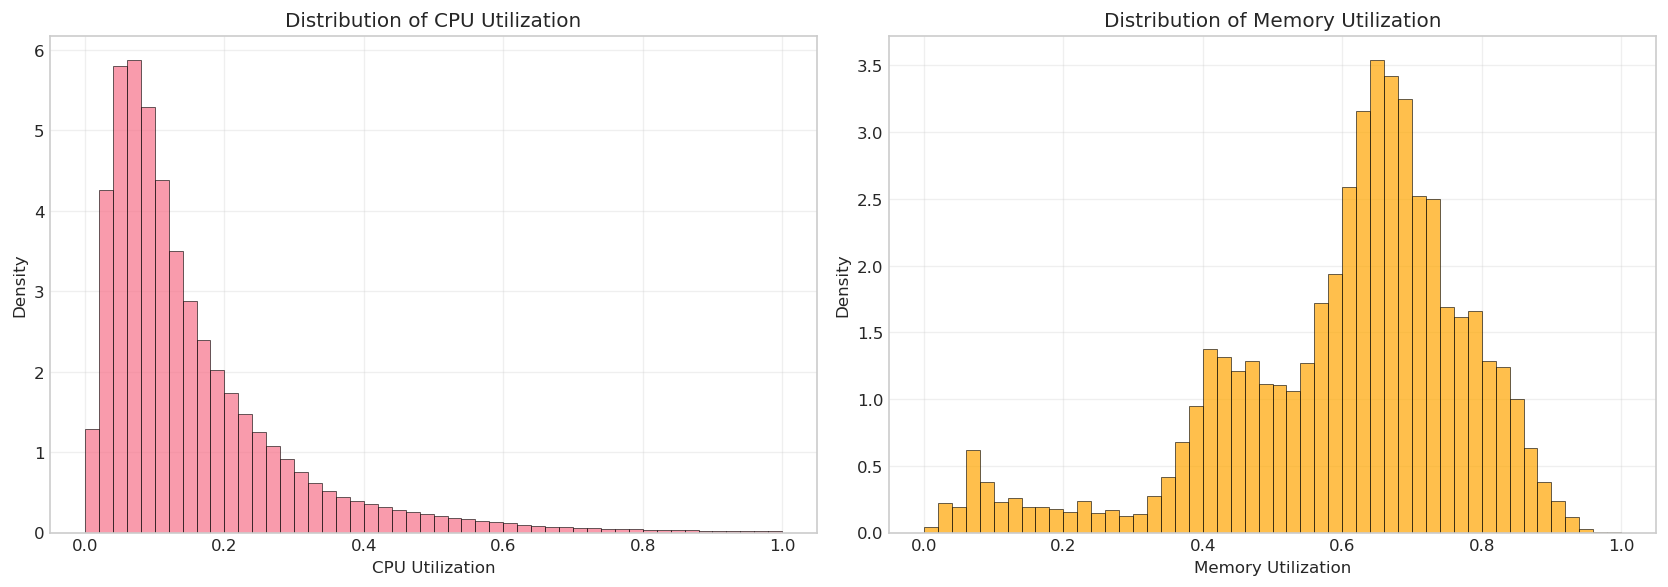

In [7]:
# Visualize distribution of CPU and memory utilization
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# CPU utilization distribution
axes[0].hist(dm.msmetrics_data['cpu_utilization'].dropna(), bins=50, 
             density=True, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('CPU Utilization')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of CPU Utilization')
axes[0].grid(True, alpha=0.3)

# Memory utilization distribution
axes[1].hist(dm.msmetrics_data['memory_utilization'].dropna(), bins=50,
             density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color='orange')
axes[1].set_xlabel('Memory Utilization')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Memory Utilization')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_CONFIG.figures_path, 'utilization_distribution.png'), dpi=150)
plt.show()


## 4. Prepare Data for Prediction


In [8]:
# Select a microservice for prediction
# Choose one with sufficient data points
MIN_DATA_POINTS = 200

# Find services with enough data
service_candidates = []
for svc, count in top_services:
    if count >= MIN_DATA_POINTS:
        service_candidates.append((svc, count))

print(f'Found {len(service_candidates)} services with >= {MIN_DATA_POINTS} data points')

if service_candidates:
    # Select the service with most data
    selected_service = service_candidates[0][0]
    print(f'\nSelected service for prediction: {selected_service}')
    print(f'Data points: {service_candidates[0][1]:,}')
else:
    print('No suitable service found. Please load more data.')


Found 20 services with >= 200 data points

Selected service for prediction: MS_6945
Data points: 5,543,522


In [9]:
# Prepare time series data for the selected service
if 'selected_service' in dir():
    ts_data = dm.prepare_service_data(
        selected_service,
        features=['cpu_utilization', 'memory_utilization'],
        normalize=True,
        add_features=False  # Set to True to add lag/rolling features
    )
    
    if ts_data is not None:
        print(f'Time series shape: {ts_data.shape}')
        print(f'Features: {ts_data.columns.tolist()}')
        print(f'\nTime series statistics:')
        print(ts_data.describe())
    else:
        print('Failed to prepare time series data')


Time series shape: (720, 2)
Features: ['cpu_utilization', 'memory_utilization']

Time series statistics:
       cpu_utilization  memory_utilization
count       720.000000          720.000000
mean          0.466272            0.434982
std           0.273783            0.260686
min           0.000000            0.000000
25%           0.233507            0.231655
50%           0.448085            0.364727
75%           0.725961            0.695041
max           1.000000            1.000000


In [10]:
# Create DataLoaders
if 'ts_data' in dir() and ts_data is not None:
    print('Creating DataLoaders...')
    print(f'Sequence length: {MODEL_CONFIG.seq_length}')
    print(f'Prediction horizon: {MODEL_CONFIG.pred_length}')
    print(f'Batch size: {MODEL_CONFIG.batch_size}')
    
    train_loader, val_loader, test_loader = dm.create_dataloaders(
        ts_data.values,
        target_idx=0  # Predict CPU utilization
    )
    
    # Verify data shapes
    for x, y in train_loader:
        print(f'\nBatch shapes:')
        print(f'  Input (X): {x.shape}')
        print(f'  Target (Y): {y.shape}')
        break


Creating DataLoaders...
Sequence length: 12
Prediction horizon: 1
Batch size: 64
Data split - Train: 503, Val: 109, Test: 108
Train samples: 491
Val samples: 97
Test samples: 96

Batch shapes:
  Input (X): torch.Size([64, 12, 2])
  Target (Y): torch.Size([64, 1])


## 5. Model Training


In [11]:
# Check for GPU availability and compatibility
import torch

def check_gpu_compatibility():
    """Check if GPU is available and compatible with PyTorch."""
    print("=" * 60)
    print("GPU COMPATIBILITY CHECK")
    print("=" * 60)
    
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        
        # Test if CUDA actually works
        try:
            test_tensor = torch.zeros(1).cuda()
            test_result = test_tensor + 1
            del test_tensor, test_result
            print("\n✓ CUDA test passed! GPU can be used.")
            return 'cuda'
        except RuntimeError as e:
            print(f"\n✗ CUDA test failed: {e}")
            print("\nNote: Your GPU (RTX 5090) uses Blackwell architecture which may")
            print("require PyTorch 2.5+ with CUDA 13 support. Using CPU instead.")
            return 'cpu'
    else:
        print("\nNo CUDA-capable GPU detected. Using CPU.")
        return 'cpu'

# Run compatibility check
recommended_device = check_gpu_compatibility()
print(f"\nRecommended device: {recommended_device}")

# Set device for this notebook
device = torch.device(recommended_device)
print(f"Using device: {device}")


GPU COMPATIBILITY CHECK
PyTorch version: 2.10.0.dev20251207+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 5090
GPU Memory: 33.67 GB

✓ CUDA test passed! GPU can be used.

Recommended device: cuda
Using device: cuda


In [12]:
# Train LSTM model
if 'train_loader' in dir():
    input_size = ts_data.shape[1]  # Number of features
    output_size = MODEL_CONFIG.pred_length
    
    print(f'Input size: {input_size}')
    print(f'Output size: {output_size}')
    
    # Run LSTM experiment
    lstm_results, lstm_trainer = run_deep_learning_experiment(
        model_type='lstm',
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        input_size=input_size,
        output_size=output_size,
        num_epochs=30  # Adjust as needed
    )


Input size: 2
Output size: 1

Running Experiment: LSTM
Model parameters: 54,913
Using device: cuda


Starting Training
  Epochs: 30
  Batch size: 64
  Learning rate: 0.001
Epoch [1/30] Train Loss: 0.124825 Val Loss: 0.462703 Train MAE: 0.304178 Val MAE: 0.675295 Time: 0.66s
Epoch [10/30] Train Loss: 0.009453 Val Loss: 0.048380 Train MAE: 0.073680 Val MAE: 0.203022 Time: 0.06s
Epoch [20/30] Train Loss: 0.004759 Val Loss: 0.004106 Train MAE: 0.054633 Val MAE: 0.047214 Time: 0.06s
Epoch [30/30] Train Loss: 0.005193 Val Loss: 0.004251 Train MAE: 0.054204 Val MAE: 0.047188 Time: 0.05s

Training completed in 2.17s
Best validation loss: 0.004106 at epoch 20

LSTM Evaluation Results:
----------------------------------------
  MSE:   0.002802
  RMSE:  0.052938
  MAE:   0.039632
  MAPE:  4.48%
  SMAPE: 4.58%
  R²:    0.175662


In [13]:
# Train GRU model
if 'train_loader' in dir():
    gru_results, gru_trainer = run_deep_learning_experiment(
        model_type='gru',
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        input_size=input_size,
        output_size=output_size,
        num_epochs=30
    )



Running Experiment: GRU
Model parameters: 40,129
Using device: cuda
Starting Training
  Epochs: 30
  Batch size: 64
  Learning rate: 0.001
Epoch [1/30] Train Loss: 0.090825 Val Loss: 0.341563 Train MAE: 0.244308 Val MAE: 0.578710 Time: 0.07s
Epoch [10/30] Train Loss: 0.007495 Val Loss: 0.023458 Train MAE: 0.063136 Val MAE: 0.141579 Time: 0.05s
Epoch [20/30] Train Loss: 0.005461 Val Loss: 0.003963 Train MAE: 0.054896 Val MAE: 0.045550 Time: 0.05s

Early stopping at epoch 27

Training completed in 1.44s
Best validation loss: 0.003068 at epoch 12

GRU Evaluation Results:
----------------------------------------
  MSE:   0.002348
  RMSE:  0.048452
  MAE:   0.038776
  MAPE:  4.45%
  SMAPE: 4.48%
  R²:    0.309474


In [14]:
# Train Attention-LSTM model
if 'train_loader' in dir():
    attention_results, attention_trainer = run_deep_learning_experiment(
        model_type='attention_lstm',
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        input_size=input_size,
        output_size=output_size,
        num_epochs=30
    )



Running Experiment: ATTENTION_LSTM
Model parameters: 57,026
Using device: cuda
Starting Training
  Epochs: 30
  Batch size: 64
  Learning rate: 0.001
Epoch [1/30] Train Loss: 0.139314 Val Loss: 0.549756 Train MAE: 0.327611 Val MAE: 0.736905 Time: 0.15s
Epoch [10/30] Train Loss: 0.016555 Val Loss: 0.158782 Train MAE: 0.100794 Val MAE: 0.388434 Time: 0.06s
Epoch [20/30] Train Loss: 0.009488 Val Loss: 0.018092 Train MAE: 0.074070 Val MAE: 0.112257 Time: 0.07s
Epoch [30/30] Train Loss: 0.006522 Val Loss: 0.020947 Train MAE: 0.061480 Val MAE: 0.123884 Time: 0.06s

Training completed in 1.98s
Best validation loss: 0.010707 at epoch 22

ATTENTION_LSTM Evaluation Results:
----------------------------------------
  MSE:   0.011891
  RMSE:  0.109045
  MAE:   0.094928
  MAPE:  10.71%
  SMAPE: 11.49%
  R²:    -2.497623


## 6. Results Comparison


In [15]:
# Compare all results
results_list = []

if 'lstm_results' in dir():
    results_list.append(lstm_results)
if 'gru_results' in dir():
    results_list.append(gru_results)
if 'attention_results' in dir():
    results_list.append(attention_results)

if results_list:
    comparison_df = pd.DataFrame(results_list)
    
    # Extract metrics
    for metric in ['mse', 'rmse', 'mae', 'mape', 'r2']:
        comparison_df[metric] = comparison_df['eval_metrics'].apply(lambda x: x[metric])
    
    comparison_df = comparison_df.drop(columns=['eval_metrics'])
    
    print('\n' + '=' * 60)
    print('MODEL COMPARISON')
    print('=' * 60)
    print(comparison_df.to_string())
    
    # Save comparison
    comparison_df.to_csv(
        os.path.join(EXPERIMENT_CONFIG.results_path, 'model_comparison.csv'),
        index=False
    )



MODEL COMPARISON
       model_type  num_params  best_val_loss  best_epoch  training_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [16]:
# Summary
print('=' * 60)
print('EXPERIMENT SUMMARY')
print('=' * 60)

print(f'\nDataset: Alibaba Microservices Trace v2022')
print(f'Target: {EXPERIMENT_CONFIG.target_variable}')
print(f'Sequence length: {MODEL_CONFIG.seq_length}')
print(f'Prediction horizon: {MODEL_CONFIG.pred_length}')

if 'comparison_df' in dir() and len(comparison_df) > 0:
    best_idx = comparison_df['rmse'].idxmin()
    best_model = comparison_df.loc[best_idx]
    
    print(f'\nBest Model: {best_model["model_type"].upper()}')
    print(f'  - RMSE: {best_model["rmse"]:.6f}')
    print(f'  - MAE: {best_model["mae"]:.6f}')
    print(f'  - R²: {best_model["r2"]:.6f}')

print(f'\nResults saved to: {EXPERIMENT_CONFIG.results_path}')
print(f'Figures saved to: {EXPERIMENT_CONFIG.figures_path}')


EXPERIMENT SUMMARY

Dataset: Alibaba Microservices Trace v2022
Target: cpu_utilization
Sequence length: 12
Prediction horizon: 1

Best Model: GRU
  - RMSE: 0.048452
  - MAE: 0.038776
  - R²: 0.309474

Results saved to: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/results
Figures saved to: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/figures
